# Build Graph using TF-IDF

## imports 

In [52]:
%matplotlib inline
import json

import numpy as np
import pandas as pd

import scipy.sparse as sp
from scipy.spatial.distance import cosine

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

import networkx as nx
import matplotlib.pyplot as plt

## data load

In [2]:
%%time

data_path = '../../data/summary/data/train.json'
with open(data_path, 'r', encoding='utf8') as f:
    dataset = [json.loads(line) for line in f]

Wall time: 4.36 s


In [3]:
total_len = len(dataset)

In [75]:
sample_id = np.random.randint(total_len, size=1)
sample_id = int(sample_id)
sample = dataset[sample_id]

text = sample['doc']
labels = sample['labels']
summary = sample['summaries']

In [76]:
sentences = text.split('\n')

## build graph using TF-IDF

In [77]:
tfidf = TfidfVectorizer().fit(sentences)

In [78]:
tdm = tfidf.transform(sentences).toarray()

## cosine similarity matrix

In [79]:
cosine_matrix = 1 - pairwise_distances(tdm, metric="cosine")

In [80]:
cosine_matrix[0]

array([1.        , 0.13233826, 0.13699356, 0.02633528, 0.30318825,
       0.05684498, 0.07668618, 0.03966142, 0.02882541, 0.05865482,
       0.18338143, 0.05904275, 0.14913155, 0.06342924, 0.13223111,
       0.16564332, 0.05299696, 0.06950596, 0.16495143, 0.01506479,
       0.05850372, 0.04209113, 0.08295206, 0.07487618])

## adjacency matrix using threshold

In [81]:
threshold = 0.15

adj_matrix = (cosine_matrix > threshold) * 1

In [82]:
# adj_matrix

## create Graph using Networkx

In [97]:
G = nx.from_numpy_matrix(cosine_matrix)

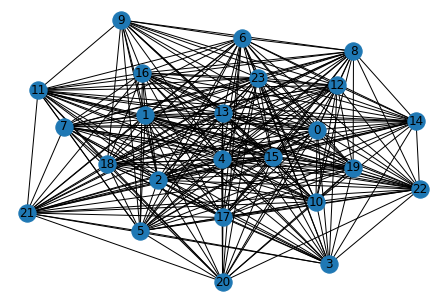

In [99]:
nx.draw(G, with_labels=True)

## Apply GDC

### imports

In [100]:
import torch_geometric.transforms as T

from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, from_scipy_sparse_matrix
from torch_geometric.utils import to_networkx

In [101]:
# Graph to SparseMatrix
G = nx.to_scipy_sparse_matrix(G)

# sparse Matrix to Graph
edge_index, edge_attr = from_scipy_sparse_matrix(G)

In [102]:
data = Data(edge_index=edge_index, edge_attr=edge_attr)

In [103]:
gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
            normalization_out='col',
            diffusion_kwargs=dict(method='ppr', alpha=0.05),
            sparsification_kwargs=dict(method='topk', k=10,
                                           dim=0), exact=True)
data = gdc(data)

D:\miniconda3\envs\pt-py36\lib\site-packages\torch_geometric\data\data.py:184: UserWarning: The number of nodes in your data object can only be inferred by its edge indices, and hence may result in unexpected batch-wise behavior, e.g., in case there exists isolated nodes. Please consider explicitly setting the number of nodes for this data object by assigning it to data.num_nodes.
  warnings.warn(__num_nodes_warn_msg__.format('edge'))


In [104]:
G = to_networkx(data, to_undirected=True)

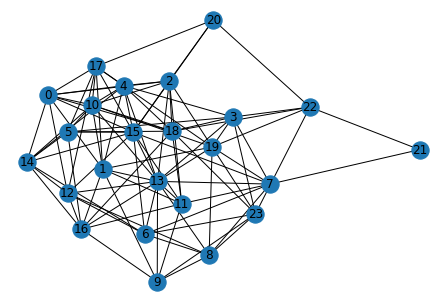

In [105]:
nx.draw(G, with_labels=True)

In [121]:
# nx.adjacency_matrix(G).toarray().shape

### Check GDC Result

#### GDC 적용 후 Degree가 높은 순으로 정렬 했을 때 Label과 비교

In [106]:
from collections import Counter

In [107]:
degree_c = Counter(dict(G.degree))

In [108]:
# k = 10
# top_n = degree_c.most_common(k)
top_n = [idx for idx, deg in degree_c.items() if deg >= degree_c[0]]
top_n

[0, 1, 2, 4, 10, 13, 15, 17, 18, 19]

In [109]:
label = labels.split('\n')
label = list(map(int, label))
label = np.array(label)

In [110]:
label[top_n]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [111]:
label

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0])